In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import os
import glob
warnings.filterwarnings('ignore')
%matplotlib inline

### Analytics - Part1 (Cohort, LTV, Retention)
- Cohort-wise # of Clients
- Cohort-wise LTV
- Cohort-wise Retention rate
*******************************************************************************************************************************************************************
### Cohort Analysis
- Cohort analysis involves extracting practical insights from past order data by dividing a customer base into distinct groups or "cohorts" and examining the behavior of each cohort over time. This approach allows you to pinpoint the impact of various customer behavior variables.

### Load data

In [9]:
path = './datasets/'
filenames = glob.glob(path + "*.csv")
file_list = []
for file in sorted(filenames):
    file_list.append(pd.read_csv(file))

customers = file_list[0]
geolocation = file_list[1]
items = file_list[2]
payments = file_list[3]
reviews = file_list[4]
orders = file_list[5]
products = file_list[6]
sellers = file_list[7]
categories = file_list[8]
master = pd.read_csv("./datasets/olist_master.csv")

### Cohort-wise # of Clients

In [14]:
# id_uid = dict(zip(customers.customer_id, customers.customer_unique_id))
# tdf = orders.copy()
# tdf['customer_unique_id'] = tdf.customer_id.map(id_uid)
tdf = master.copy()

In [16]:
# feature engineering
tdf.order_purchase_timestamp = pd.to_datetime(tdf.order_purchase_timestamp)
tdf['order_month'] = tdf.order_purchase_timestamp.dt.to_period('M')
tdf['first_purchase'] = tdf.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

In [18]:
df_cohort = tdf.groupby('first_purchase').agg({'customer_unique_id': 'nunique'}).rename(columns = {'customer_unique_id':'count'})

In [19]:
df_cohort.T

first_purchase,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
count,2,304,1,771,1614,2365,2038,2906,2416,2804,...,3556,2341,2616,2135,1988,1690,1414,1094,1066,939


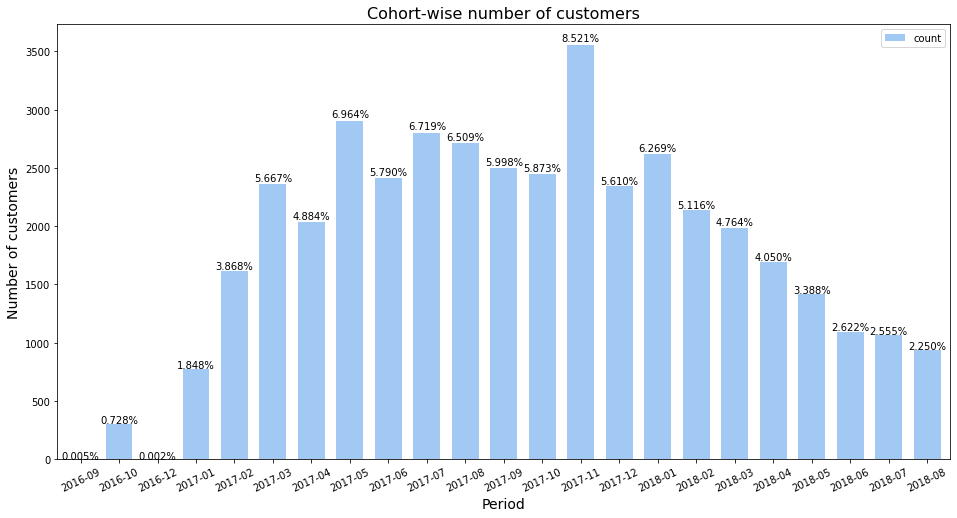

In [20]:
colors = sns.color_palette('pastel',len(df_cohort))

ax = df_cohort.plot(kind='bar',figsize=(16,8),width = 0.7, color = colors)
plt.xlabel("Period", fontsize = 14) 
plt.ylabel('Number of customers', fontsize=14)
plt.xticks(rotation=25)
plt.title("Cohort-wise number of customers", fontsize=16)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / df_cohort['count'].values.sum()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3%}', (x + width/2, y + height*df_cohort['count'].values.sum().sum()*1.01), ha='center')

- From 2016-09 to 2016-12, there are few customers so that let's exclude them in the following cohort analysis

### Cohort-wise LTV
- Cohort analysis can be used in different ways. When calculating customer LTV, it involves grouping customers based on their first order date and tracking how much an average customer from each group is worth to your business over time. Instead of a single average LTV, you get a matrix of LTV "snapshots" for each cohort based on the time since their first orders.

In [24]:
df_ltv = tdf.copy()
df_ltv = df_ltv[(df_ltv.first_purchase >= '2017-01') & (df_ltv.order_month >= '2017-01')]
df_ltv = df_ltv[['first_purchase', 'order_month', 'customer_unique_id', 'order_id', 'payment_value']]
df_ltv

,first_purchase,order_month,customer_unique_id,order_id,payment_value
0,2017-09,2017-09,5ee8fe956c2631afc0a1dcc1920d0e3d,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,2017-06,2017-06,8b3f917f4307d3e5cf34c0b43d6e6f50,130898c0987d1801452a8ed92a670612,73.86
2,2017-06,2018-05,69ba88e17ea574da9c9b8c8834a583d1,532ed5e14e24ae1f0d735b91524b98b9,83.23
3,2017-06,2017-08,cbe063493a222cb17024ff0285b4ecb6,6f8c31653edb8c83e1a739408b5ff750,75.07
4,2017-07,2017-08,ffab5330bd7b40979ab6726b2e02292e,7d19f4ef4d04461989632411b7e588b9,72.19
...,...,...,...,...,...
116576,2017-04,2017-04,e060eb8f37de232154b24bbb2413b68e,fdaf98feac227eb978d8f33f36e0231d,136.04
116577,2017-01,2017-08,3041f5d65c4fa516eed1325d7a8657af,fe68b52db13993f58175fa589125d345,225.21
116578,2017-02,2018-07,57b628f46c00f9a7358e5e875d5b4dd0,fefacc66af859508bf1a7934eab1e97f,6922.21
116579,2018-01,2018-04,ea4d52b176423e61a84052b0f4717be9,ff701a7c869ad21de22a6994237c8a00,84.68


- Let's create the LTV report using cohort analysis based on the first purchase date

In [25]:
from operator import attrgetter

df_cohort = df_ltv.groupby(['first_purchase', 'order_month'])['payment_value'].sum().reset_index()
df_cohort['month since first order'] = (df_cohort.order_month - df_cohort.first_purchase).apply(attrgetter('n'))
n_customers = dict(zip(tdf.groupby('first_purchase')[['customer_unique_id']].nunique().reset_index().first_purchase, tdf.groupby('first_purchase')[['customer_unique_id']].nunique().reset_index().customer_unique_id))
df_cohort['new customers'] = df_cohort['first_purchase'].map(n_customers)
df_cohort.head()

,first_purchase,order_month,payment_value,month since first order,new customers
0,2017-01,2017-01,187054.16,0,771
1,2017-01,2017-02,5058.07,1,771
2,2017-01,2017-03,7939.66,2,771
3,2017-01,2017-04,6184.37,3,771
4,2017-01,2017-05,11273.23,4,771


In [26]:
df_pivot = df_cohort.pivot_table(index = ['first_purchase', 'new customers'],
                                 columns = 'month since first order',
                                 values = 'payment_value')
df_pivot = df_pivot.divide(df_pivot.index.get_level_values(1), axis=0)
df_pivot = df_pivot.cumsum(axis=1)
df_pivot

,month since first order,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first_purchase,new customers,,,,,,,,,,,,,,,,,,,,
2017-01,771,242.612399,249.172802,259.470674,267.491907,282.113476,303.705084,316.891660,338.818431,351.396057,369.389507,404.500960,430.891855,464.172607,484.487341,515.589922,541.795746,572.990220,597.194358,665.735071,688.536939
2017-02,1614,203.162088,213.042639,224.138401,243.707608,253.567218,268.693154,287.346059,307.121679,327.671276,359.685328,379.539449,407.308222,430.350886,466.158024,496.714938,531.973352,555.397423,588.352299,614.073581,NaN
2017-03,2365,208.358216,217.596034,230.232664,243.287298,258.466600,273.581877,294.206051,315.951235,351.409222,374.743514,402.349142,430.639332,463.334723,493.404930,522.813226,554.340748,575.915044,601.885357,NaN,NaN
2017-04,2038,218.529583,234.101909,244.529372,259.450324,275.233538,294.851526,314.647125,341.510064,362.547964,395.545677,419.337924,457.374495,488.025363,525.709868,551.678449,578.449568,606.217920,606.299598,NaN,NaN
2017-05,2906,208.344504,224.077047,238.379683,262.906555,283.986573,305.965719,340.564439,360.149002,386.397395,415.669474,444.332478,476.139659,505.552089,530.943121,560.441318,588.526332,NaN,NaN,NaN,NaN
2017-06,2416,191.256246,208.948994,223.606883,243.447413,258.617976,290.872392,314.271925,344.372570,364.032993,392.875228,418.117016,448.404131,470.806267,504.848957,535.139404,NaN,NaN,NaN,NaN,NaN
2017-07,2804,195.568359,213.060813,271.586616,292.657992,323.471648,342.250728,379.602443,421.110250,454.654116,489.083384,520.669650,544.438470,567.180364,588.887546,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,2716,219.010353,240.783052,260.692228,292.145501,314.272894,342.157559,369.915217,405.199297,441.392695,472.104293,498.664061,522.535832,548.147603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,2503,217.712393,237.644467,272.228470,295.010148,326.451946,353.360643,379.984071,404.622960,432.531966,466.007359,489.733408,510.925110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cohort-wise Monthly Retention Rate

In [27]:
df_retention = df_ltv.groupby(['first_purchase', 'order_month'])['customer_unique_id'].nunique().reset_index()
df_retention['month since first order'] = (df_retention.order_month - df_retention.first_purchase).apply(attrgetter('n'))
df_retention

,first_purchase,order_month,customer_unique_id,month since first order
0,2017-01,2017-01,771,0
1,2017-01,2017-02,30,1
2,2017-01,2017-03,42,2
3,2017-01,2017-04,34,3
4,2017-01,2017-05,68,4
...,...,...,...,...
206,2018-06,2018-07,125,1
207,2018-06,2018-08,145,2
208,2018-07,2018-07,1066,0
209,2018-07,2018-08,135,1


In [28]:
retention_pivot = df_retention.pivot_table(index = 'first_purchase',
                                 columns = 'month since first order',
                                 values = 'customer_unique_id')
retention_report = (retention_pivot.divide(retention_pivot.iloc[:, 0], axis=0) * 100).round(3)
retention_report

month since first order,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first_purchase,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,3.891,5.447,4.410,8.820,8.431,8.301,8.171,6.615,8.171,15.045,11.284,15.175,11.284,13.359,13.748,11.673,12.062,13.359,9.598
2017-02,100.0,5.576,4.337,8.364,6.196,8.488,8.178,8.426,9.108,13.817,10.409,13.383,13.321,14.684,13.259,13.817,11.214,11.029,11.710,NaN
2017-03,100.0,4.778,7.188,6.850,7.188,8.753,8.457,9.979,13.150,10.909,13.319,13.404,14.841,12.389,13.319,12.516,12.643,12.770,NaN,NaN
2017-04,100.0,6.673,6.084,7.360,8.096,8.685,8.979,13.150,10.157,14.818,11.874,13.101,13.886,14.622,12.316,12.758,14.475,0.049,NaN,NaN
2017-05,100.0,6.469,7.433,9.670,8.362,9.153,14.831,10.530,12.801,13.111,13.111,12.663,13.558,12.147,12.388,12.319,NaN,NaN,NaN,NaN
2017-06,100.0,8.444,8.030,8.485,8.858,13.079,11.217,13.866,12.417,13.907,12.127,13.783,11.796,12.169,12.334,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,9.094,8.417,8.666,14.123,10.913,13.481,13.980,13.944,13.088,13.124,11.983,12.019,12.803,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,8.432,9.389,13.292,10.383,13.918,13.623,12.703,13.586,12.960,12.003,11.598,11.745,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,9.069,16.061,10.467,14.263,13.464,13.464,13.544,12.625,11.786,12.026,11.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
